In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('hf://datasets/nprak26/remote-worker-productivity/remote_work_productivity.csv')
df

,Employee_ID,Age,Years_Experience,WFH_Days_Per_Week,Gender,Education_Level,Marital_Status,Has_Children,Location_Type,Department,Job_Level,Company_Size,Industry,Home_Office_Quality,Internet_Speed_Category,Work_Hours_Per_Week,Manager_Support_Level,Team_Collaboration_Frequency,Productivity_Score,Task_Completion_Rate,Quality_Score,Innovation_Score,Efficiency_Rating,Meetings_Per_Week,Commute_Time_Minutes,Job_Satisfaction,Stress_Level,Work_Life_Balance,Survey_Date,Response_Quality
0,EMP0001,39,10,2,Female,Associate Degree,Married,Yes,Urban,Product,Mid-Level,Large (1001-5000),Finance,Good,Very Fast (100+ Mbps),41,Low,Few times per week,52.2,56.6,58.1,52.1,72.1,4,48,55.9,6,8,2024-04-05,Medium
1,EMP0002,33,4,5,Female,Master Degree,Married,No,Urban,Customer Success,Senior,Startup (1-50),Education,Good,Very Fast (100+ Mbps),52,Moderate,Monthly,81.5,70.8,93.3,77.9,89.5,12,0,96.1,3,8,2024-01-29,High
2,EMP0003,40,3,3,Male,PhD,Single,Yes,Rural,Operations,Mid-Level,Medium (201-1000),Technology,Excellent,Fast (50-100 Mbps),43,Moderate,Few times per week,82.2,81.9,84.7,63.2,95.0,15,24,90.4,5,6,2024-01-18,High
3,EMP0004,48,14,3,Male,Bachelor Degree,Married,Yes,Urban,Finance,Manager,Medium (201-1000),Technology,Excellent,Very Fast (100+ Mbps),45,High,Daily,75.6,70.2,67.8,82.5,95.0,8,8,100.0,10,5,2024-04-18,High
4,EMP0005,32,6,5,Male,High School,Divorced,Yes,Rural,Engineering,Senior,Small (51-200),Technology,Average,Moderate (25-50 Mbps),42,Very Low,Few times per week,98.0,98.2,86.4,67.5,95.0,10,0,100.0,3,4,2024-02-19,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,EMP1496,53,5,5,Male,Master Degree,Married,No,Urban,HR,Senior,Startup (1-50),Education,Good,Fast (50-100 Mbps),36,Moderate,Weekly,78.5,89.7,84.1,58.3,89.4,9,0,71.4,8,5,2024-03-18,High
1496,EMP1497,53,9,3,Non-binary,Master Degree,Married,Yes,Suburban,Finance,Mid-Level,Small (51-200),Technology,Average,Very Fast (100+ Mbps),43,Moderate,Weekly,74.7,71.9,74.7,54.2,87.2,3,11,95.8,8,8,2024-05-13,High
1497,EMP1498,45,2,4,Male,Associate Degree,Single,Yes,Suburban,Engineering,Junior,Large (1001-5000),Technology,Average,Moderate (25-50 Mbps),51,Very High,Weekly,88.6,92.9,88.4,71.2,95.0,11,34,100.0,4,5,2024-04-15,High
1498,EMP1499,44,12,4,Female,Bachelor Degree,Single,Yes,Suburban,Operations,Senior,Large (1001-5000),Technology,Average,Fast (50-100 Mbps),26,Very High,Daily,92.1,74.2,93.9,88.6,95.0,10,6,100.0,3,6,2024-02-21,Medium


# Data Preprocessing & Pipelines

Prior to splitting the dataset, we drop unnecessary columns that will not assist the model in training and learning, such as Employee_ID and Survey_Date. We also drop Productivity_Score because that is our target column (the values we want the model to predict accurately) and the model should not see this column during training. After removing these columns, we split the data using an 80/20 split, where 80% of the dataset is used for training and the remaining 20% is used for testing.

To prepare the dataset for the model’s training, we build two separate preprocessing pipelines: the Numerical Pipeline and the Categorical Pipeline. The Numerical Pipeline uses an imputer to fill missing numerical values with the median computed within each column, and a scaler to standardize numerical features so they have a mean of 0 and a standard deviation of 1, which helps optimize model learning. The Categorical Pipeline uses an imputer to fill missing categorical values with the most frequent value in each column, and a OneHotEncoder to convert categories into binary indicator columns, allowing the model to learn effectively from non-numeric data.

After the data is preprocessed, we create two additional pipelines. The first one combines the numerical and categorical pipelines using a ColumnTransformer, allowing each feature type to be processed correctly in a single unified step. The second pipeline integrates this preprocessor with the model itself, where we use a Random Forest Regressor as the final estimator.

In [33]:
# Remove label column and unecessary features
X = df.drop(['Productivity_Score', 'Employee_ID', 'Survey_Date'], axis=1)
y = df['Productivity_Score']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separate categorical and numerical features
cat_features = X_train.select_dtypes(include='object').columns.tolist()
num_features = X_train.select_dtypes(exclude='object').columns.tolist()

# Numeric pipeline for scaler
# Fill N/A values with the median of the column
# Scalar used to standardize numerical features to have mean 0 and std. 1
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline for onehot encoding
# Fill N/A values with most_frequent of the column
# Convert categories into binary columns
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Add regressor model (RandomForestRegressor)
reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# GridSearch (Finding best hyperparameters)

In [35]:
from sklearn.model_selection import GridSearchCV

# hyperparameter grid for Random Forest Regressor
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

# GridSearchCV
# Will try every possible combination of hyperparams to find best model
grid = GridSearchCV(
    reg,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid.fit(X_train, y_train)

print("Best hyperparameters for Random Forest Regressor:")
print(grid.best_params_)
print(grid.best_score_)

Best hyperparameters for Random Forest Regressor:
{'regressor__max_depth': 20, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
-17.103204542057682


**The Best Hyperparameters for Random Forest Regressor**
* max_depth:: None
* min_samples_split: 2
* n_estimators: 200

# Evaluate best model on test set

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Save the best-performing model found by GridSearchCV
# Generate predictions with test set using best model
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)

# Evaluation metrics RMSE, MAE, R2
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 3.957927798586026
MAE: 3.093982843119108
R2 Score: 0.9235457274935099


**Evaluation Interpretation**

MAE = 3.0940
* The average size of the errors were off by about 3.
* When the productivity is on the range of 35-98, a model with an error of about 3 is great.
* Large mistakes aren't penalized however.

RMSE = 3.9579
* Larger errors are penalized, thus large errors increase RMSE score.
* Because RMSE is higher than MAE, MAE failed to showcase bad and far off predictions.

R2 = 0.9235
* The model does a good job at detecting the variances that determines worker productivity.
* 92% of the time, given the worker's features (e.g. education level, WFH hours, etc.) the model is able to accurately predict the productivity_score.

# Feature Importance

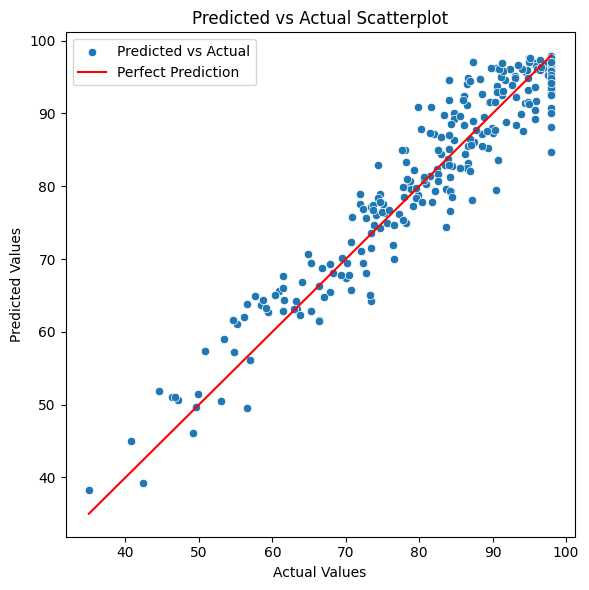

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# Scatter plot of actual vs predicted values
# If observation is close to line, model is more accurate
sns.scatterplot(x=y_test, y=y_test_pred, label="Predicted vs Actual")

# Create red reference line (y=x)
# Represents perfect predictions
# Closer points are to line, the more accurate the model
min_val = min(min(y_test), min(y_test_pred))
max_val = max(max(y_test), max(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color="red", label="Perfect Prediction")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Scatterplot")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# Extract objects
preprocessor = best_model.named_steps['preprocessor']
regressor = best_model.named_steps['regressor']

# Original feature lists
num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][2]

# Get transformed feature names
num_out = preprocessor.named_transformers_['num'].get_feature_names_out(num_features)
cat_out = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)

# Combine to full feature list
feature_names = list(num_out) + list(cat_out)

# Importances
importances = regressor.feature_importances_

# Create DF
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importances_df


,Feature,Importance
7,Efficiency_Rating,0.507399
5,Quality_Score,0.379811
4,Task_Completion_Rate,0.060810
6,Innovation_Score,0.011643
9,Commute_Time_Minutes,0.002879
...,...,...
15,Gender_Non-binary,0.000095
68,Internet_Speed_Category_Slow (<25 Mbps),0.000065
74,Manager_Support_Level_Very Low,0.000063
21,Education_Level_Professional Degree,0.000027


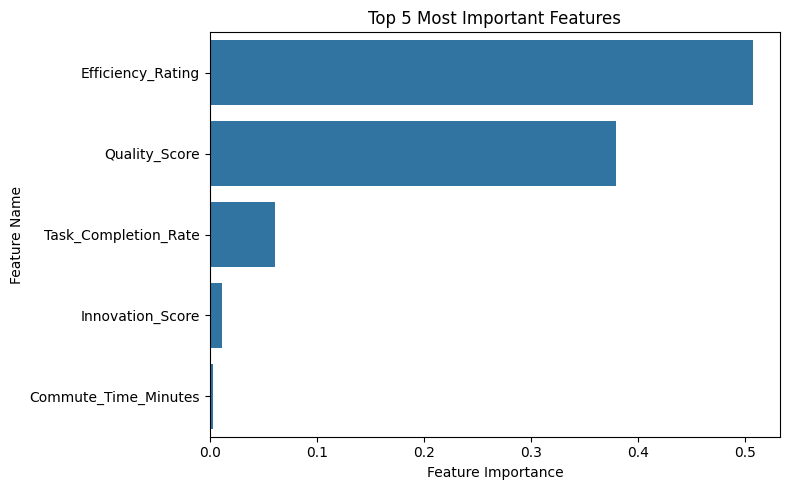

In [39]:
# Take top 5 features
top5 = feature_importances_df.head(5)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top5,
    x='Importance',
    y='Feature',

)

plt.title("Top 5 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

**Model's Feature Importance Rating**

Efficiecy_Rating = 0.507399
* Influences almost 50% of how the model predicts a worker's productivity.
* Efficiency is measured by the worker's time management x resources used at work.
* This means the model heavily relies on how efficiently someone works to estimate their final productivity score.

Quality_Score = 0.379811
* Contributes to about 37% of the model's predictions.
* Quality reflects how well the work is done (accuracy, completeness, attention to detail, etc.).
* This suggests that even if someone works fast, the quality of the output is also a major driver in predicting productivity.

Task_Completion_Rate = 0.060810
* Only 6% influence on the model's predictions.
* This means completing tasks consistently matters, but not nearly as much as how efficiently or how well the tasks are performed.


Innovatinon_Score = 0.011643
* Has a very small impact of about 1%.
* Creativity and innovative contributions appear to play a minor role in determining productivity according to the model.

Commute_Time_Minutes = 0.002879
* Contributes to only 0.3%, meaning it has almost no effect on predictions.
